<a href="https://colab.research.google.com/github/Lino-ver2/product_development/blob/main/Unet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U_Netによる生成モデルの作成
<br>U_net構造に加え、訓練データに意図的なノイズを混ぜることでノイズを認識させることを目的とする.
<br>ノイズを混ぜたデータと混ぜていないデータを別々のモデルに訓練させノイズの効果を確認する.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/MyDrive/Colab_Notebooks/Unet/"

Mounted at /content/drive/
/content/drive/MyDrive/Colab_Notebooks/Unet


In [ ]:
import pathlib
import pickle
from collections import deque

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.io import read_image
from torchvision import transforms

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## データ準備
<br>前回はcirfar10を使用したが32×32 ピクセルはさすがに解像度が低い.
<br>画像を生成したときの違いが分かりにくいため178 × 218 ピクセルのCelebA Datasetを使用する.

http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
<br>
<br> ダウンロードしたデータを教師データ、訓練データとして使えるように加工していく.

In [ ]:
# 画像をtensorに変換
def image_to_tensor(img_path, target_height):
    img = pathlib.Path(img_path)
    img_path = list(img.iterdir())
    data_sets = []
    for img in img_path:
        trg = Image.open(img)
        trg = transforms.functional.resize(trg, target_height)
        trg = transforms.functional.to_tensor(trg)
        data_sets.append(trg)
    data_sets = torch.stack(data_sets)

    return data_sets

In [ ]:
# tensorにノイズを付加
def noising_mask(train_data, gaussian_rate):
    b, c, h, w = train_data.shape
    noise = torch.randn(b, c, h, w).to(device) # ノイズを生成にはガウシアン分布を使用
    train_data += (noise * gaussian_rate)

    return train_data

In [ ]:
# パイプ
def processes(img_path, split_rate=0.9, train_height=64, target_height=128, noising_flg=True, gaussian_rate=0.2):
    # 画像をtensorに変換
    data = image_to_tensor(img_path, target_height).to(device)
    # 縦長の画像を正方形にパディング
    b, c, h ,w = data.shape
    dim = data.dim()
    pad = torch.zeros(b, c, h, int((h-w)/2)).to(device)
    data = torch.cat((pad, data, pad), axis=dim-1)
    # 訓練用とテスト用に分割
    train_target = data[0:int(b*split_rate)].to(device)
    test_target = data[int(b*split_rate):].to(device)
    # 教師データサイズにダウンサンプリング
    train_target = transforms.functional.resize(train_target, target_height)
    test_target = transforms.functional.resize(test_target, target_height)
    # 入力データサイズにダウンサンプリングとノイジング
    train_data = transforms.functional.resize(train_target, train_height)
    if noising_flg:
        train_data = noising_mask(train_data, gaussian_rate) # ノイズの付加
    test_data = transforms.functional.resize(test_target, train_height) # ダウンサンプリング
    if noising_flg:
        test_data = noising_mask(test_data, gaussian_rate) # ダウンサンプリング

    return train_data, train_target, test_data, test_target

In [ ]:
# 画像の生成(配置は１行３列)
def show_img(target1, target2, target3, label=[]):
    target1 = np.transpose(target1, (1,2,0))
    target2 = np.transpose(target2, (1,2,0))
    target3 = np.transpose(target3, (1,2,0))

    fig = plt.figure(figsize=(15, 5))
    a0 = fig.add_subplot(1,3,1)
    a0.set_title('{} : {}'.format(label[0], target1.shape))
    a0.imshow(target1)

    a1 = fig.add_subplot(1,3,2)
    a1.set_title('{} : {}'.format(label[1], target2.shape))
    a1.imshow(target2)

    a2 = fig.add_subplot(1,3,3)
    a2.set_title('{} : {}'.format(label[2], target3.shape))
    a2.imshow(target3)

上記の関数から訓練・教師データを作成、保存しサンプル画像を示す.


In [ ]:
# 訓練・教師データの生成と保存
"""
img_path = ('/content/drive/MyDrive/Colab_Notebooks/data/img_align_celeba')
noising_flg = [True, False]

for flg in noising_flg:
    x_train, y_train, x_test, y_test = processes(img_path, noising_flg=flg)
    data_sets = {'x_train' : x_train, 'x_test' : x_test}
    for name, value in data_sets.items():
        with open('data_sets/{}_noise:{}.pickle'.format(name, flg), mode='wb') as f:
            pickle.dump(value, f)

with open('data_sets/y_train.pickle', mode='wb') as f:
        pickle.dump(y_train, f)
with open('data_sets/y_test.pickle', mode='wb') as f:
        pickle.dump(y_test, f)
"""

"\nimg_path = ('/content/drive/MyDrive/Colab_Notebooks/data/img_align_celeba')\nnoising_flg = [True, False]\n\nfor flg in noising_flg:\n    x_train, y_train, x_test, y_test = processes(img_path, noising_flg=flg)\n    data_sets = {'x_train' : x_train, 'x_test' : x_test}\n    for name, value in data_sets.items():\n        with open('data_sets/{}_noise:{}.pickle'.format(name, flg), mode='wb') as f:\n            pickle.dump(value, f)\n\nwith open('data_sets/y_train.pickle', mode='wb') as f:\n        pickle.dump(y_train, f)\nwith open('data_sets/y_test.pickle', mode='wb') as f:\n        pickle.dump(y_test, f)\n"

In [ ]:
# 保存した訓練・教師データのロード
with open('data_sets/x_train_noise:False.pickle', mode='rb') as f:
    x_train_False = pickle.load(f)
with open('data_sets/x_test_noise:False.pickle', mode='rb') as f:
    x_test_False = pickle.load(f)

with open('data_sets/x_train_noise:True.pickle', mode='rb') as f:
    x_train_True = pickle.load(f)
with open('data_sets/x_test_noise:True.pickle', mode='rb') as f:
    x_test_True = pickle.load(f)

with open('data_sets/y_train.pickle', mode='rb') as f:
    y_train = pickle.load(f)
with open('data_sets/y_test.pickle', mode='rb') as f:
    y_test = pickle.load(f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


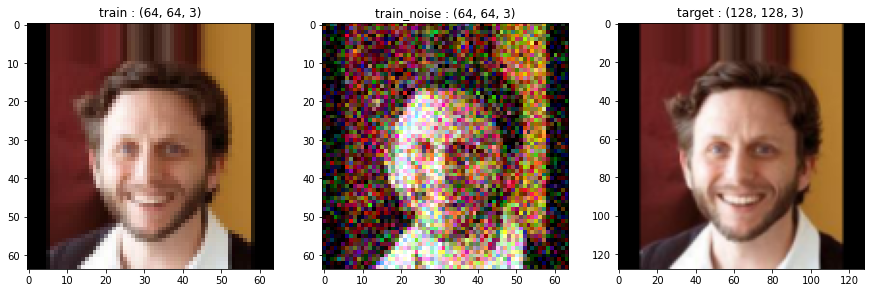

In [ ]:
# 生成した画像のプレビュー
label = ['train', 'train_noise', 'target']
index = 16
target1 = x_train_False[index].cpu().data.numpy()
target2 = x_train_True[index].cpu().data.numpy()
target3 = y_train[index].cpu().data.numpy()
show_img(target1, target2, target3, label)

左から順に訓練データ（ノイズなし）、訓練データ（ノイズあり）、教師データ
<br>訓練データ : 64×64にダウンサンプリンングしたものを使用
<br>教師データ : 128×128にダウンサンプリングしたものを使用

## U_Netアーキテクチャ
前回使用したアーキテクチャのAEのフラグを削除したものを使用.
※前回使用したアーキテクチャでは出力層もバッチ正規化と活性化関数を

In [ ]:
class Model(nn.Module):

    def __init__(self, hidden_dim):
        super(Model, self).__init__()
        stride = 2
        padding = 1
        # エンコーディング・レイヤー
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3, hidden_dim, 3, stride=stride, padding=padding), 
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU()
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim*2, 3, stride=stride, padding=padding),
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU()
        )
        self.layer_3 = nn.Sequential(
            nn.Conv2d(hidden_dim*2, hidden_dim*4, 3, stride=stride, padding=padding),
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU()
        )
        self.layer_4 = nn.Sequential(
            nn.Conv2d(hidden_dim*4, hidden_dim*8, 3, stride=stride, padding=padding),
            nn.BatchNorm2d(hidden_dim*8),
            nn.ReLU()   
        )
        # デコーディング・レイヤー
        self.layer_5 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim*8, hidden_dim*4, 4, stride=stride, padding=padding), 
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU()
        )
        self.layer_6 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim*4, hidden_dim*2, 4, stride=stride, padding=padding),
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU()
        )
        self.layer_7 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim*2, hidden_dim, 4, stride=stride, padding=padding),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU()
        )
        self.layer_8 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, int(hidden_dim/2), 4, stride=stride, padding=padding), 
            nn.BatchNorm2d(int(hidden_dim/2)),
            nn.ReLU()
        )
        # 出力層
        self.layer_9 = nn.Sequential(
            nn.ConvTranspose2d(int(hidden_dim/2), 3, 4, stride=stride, padding=padding),
        )

        self.encode_sequence = [self.layer_1, self.layer_2, self.layer_3, self.layer_4]
        self.decode_sequence = [self.layer_5, self.layer_6, self.layer_7, self.layer_8, self.layer_9]


    def forward(self, x):
        encoded_layer = deque([])
        for en in self.encode_sequence:
            x = en(x)
            encoded_layer.append(x)

        for de in self.decode_sequence:
            if deque([]) != encoded_layer: # encoded_layerに情報があればdequeで取り出す
                x = x + encoded_layer.pop()
            x = de(x)
            
        return x

## 学習
ノイズ付加（訓練データ）の有無をフラグとしてモデルを別途作成.

In [ ]:
num_epochs = 20
batch_size =100
learning_rate = 1e-3
noise_flg = [True, False]
saving = True

train_size = 6500
test_size = 700

for flg in noise_flg:
    train_loss_list = []
    # flgがTrueであればノイズを付加されたイメージを使用
    if flg:
        x_train = x_train_True[:train_size].reshape(-1, batch_size, 3, 64, 64)
        x_test = x_test_True[:test_size]
    else:
        x_train = x_train_False[:train_size].reshape(-1, batch_size, 3, 64, 64)
        x_test = x_test_False[:test_size]
    y_train = y_train[:train_size].reshape(-1, batch_size, 3, 128, 128)
    y_test = y_test[:test_size]

    # モデルの定義
    model = Model(hidden_dim=64).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # 学習
    for epoch in range(num_epochs):        
        for idx, data in enumerate(x_train):
            data = data.to(device)
            out_put = model(data)
            loss = criterion(out_put, y_train[idx].to(device))
            train_loss_list.append(float(loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    test_data = x_test.to(device)
    test_out_put = model(test_data)

    # モデルの保存
    if saving:
        model_path = 'models/u_net1(epoch:{}, batch_size:{}, noise:{}).pth'.format(str(epoch+1), str(batch_size), str(flg))
        torch.save(model.state_dict(), model_path)
        # lossリストの保存
        with open('loss_list/train_loss1(epoch:{}, batch_size:{}, noise:{}).pickle'.format(str(epoch+1), str(batch_size), str(flg)), mode='wb') as f:
            pickle.dump(train_loss_list, f)

In [ ]:
# モデル呼び出し
model_False = Model(64)
model_True = Model(64)
model1 = model_False.load_state_dict(torch.load('models/u_net1(epoch:20, batch_size:100, noise:False).pth', torch.device('cpu')))
model2 = model_True.load_state_dict(torch.load('models/u_net1(epoch:20, batch_size:100, noise:True).pth', torch.device('cpu')))
# lossリストの呼び出し
with open('loss_list/train_loss1(epoch:20, batch_size:100, noise:True).pickle', mode='rb') as f:
    train_noise_loss_list = pickle.load(f)
with open('loss_list/train_loss1(epoch:20, batch_size:100, noise:False).pickle', mode='rb') as f:
    train_loss_list = pickle.load(f)

Text(0.5, 1.0, 'train_loss(batch_size=100)')

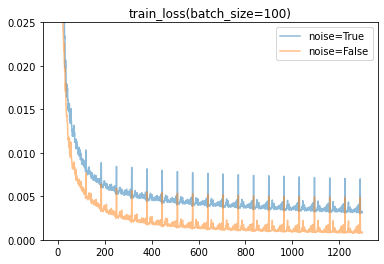

In [ ]:
# train_loss
plt.plot(train_noise_loss_list, label='noise=True', alpha=0.5)
plt.plot(train_loss_list, label='noise=False', alpha=0.5)
plt.ylim(0,0.025)
plt.legend()
plt.title('train_loss(batch_size=100)')

lossにおいてはノイズで訓練したモデルの方が、そうでないモデルより大きいようだ.
<br>ノイズを付加した画像の方が教師データとの異差が大きいことから納得のいく結果である.
<br>以下にテスト画像（ノイズ無し）を付与して画像を生成させてみる.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


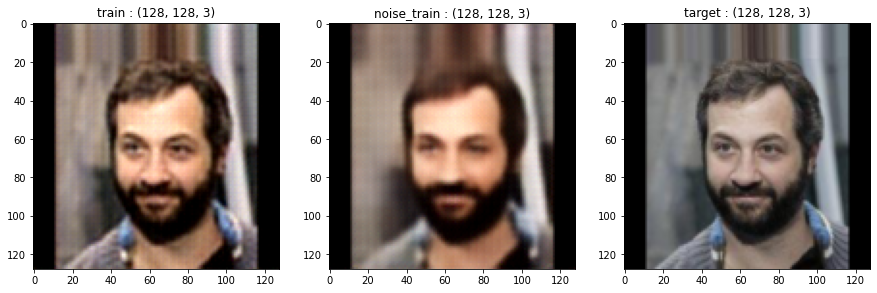

In [ ]:
index = 17
label = ['train', 'noise_train', 'target']
target = x_test_False[index].reshape(1, 3, 64, 64)
target1 = model_False(target).reshape(3, 128, 128).cpu().detach().numpy()
target2 = model_True(target).reshape(3, 128, 128).cpu().detach().numpy()
target3 = y_test[index].detach().numpy()
show_img(target1, target2, target3, label)

(左からノイズなしのモデル、ノイズありのモデル、正解データ)
<br>ノイズなしのモデルの方が教師データに近い画像を生成している.

<br>以下はノイズありのデータを与えたもの.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


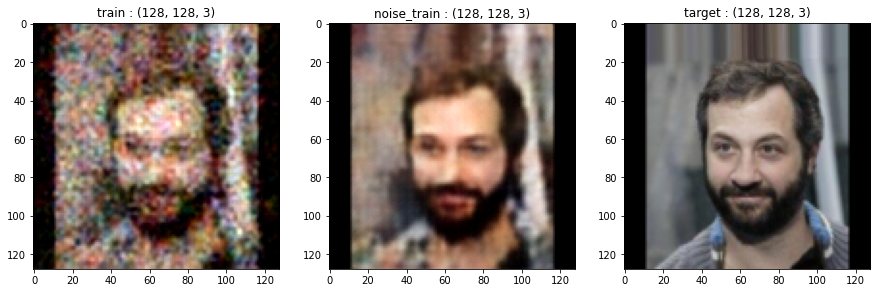

In [ ]:
index = 17
label = ['train', 'noise_train', 'target']
target = x_test_True[index].reshape(1, 3, 64, 64)
target1 = model_False(target).reshape(3, 128, 128).cpu().detach().numpy()
target2 = model_True(target).reshape(3, 128, 128).cpu().detach().numpy()
target3 = y_test[index].detach().numpy()
show_img(target1, target2, target3, label)

ノイズありのモデルの方がノイズを認識していることがわかる.

## 考察
loss_listのグラフをみる限りノイズなしの訓練データ方が学習が早いようだ.
<br>ノイズなしのデータの方が、教師データに近いぶん学習が早いのかもしれない.
<br>ただしノイズを含めた画像を与えるとノイズありのモデルの方が特徴をしっかり捉えていることがわかる.
<br>ノイズを認識させることには成功しているようだ.


<br>下記はアーキテクチャの改善点について.
<br>エンコード・デコード時にはたった一枚の層でダウン・アップサンプリングを繰り返している.
<br>パラメータの数が少ないため次のエンコード・デコード時に適切な情報を伝えられていないのではないか.
<br>精度の高い高解像度化を目指すのであれば各層に畳み込みを追加してみると良いかもしれない.
<br>特にデコード時はインプットよりもアップサンプリングをした状態で出力されるため層が少なければ良い精度は望めないと思う.
